
# Topic Assignment: Feature Extraction from Time Series Data

**Note:** This notebook file for the assignment has deviations from the course guide with respect to the structure, sentence framing, question framing and numbering. Please consider this notebook file structure as the final structure and follow this.


For markdown cheat sheet see: https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet - This is just for your additional reference to help you with typing and presenting your answers in the cells in notebook files and is not a part of the assignment.

Student Name:  Evan Franciszok                        
Reg No:  
Group No:   26

## Instructions
We will use this jupyter note book to complete TS assignment. Please provide answer at the designated place only. After the assignment is completed convert the Notebook to PDF and submit it on Canvas. While creating PDF make sure that output is clearly visible.
Submit also this complete notebook. This means you are required to submit two files:
1. Jupytor Notebook
2. PDF file

## UCI HAR activity recognition data set
This dataset will be used for **Exercise 4.1-4.8**.

For classifying time series data, we will work with an activity recognition
data from inertial sensors (e.g., accelerometer and gyroscope). It
has both raw data and derived features from the raw data. You can find more information about this dataset in this link - https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

You can also download data from Canvas.

The basic description about the dataset and the files are given in the *UCI HAR Dataset -->
README.txt*

## Understanding the Dataset
Read instructions from the Topic Guide.
### Pre-Processing and Windowing
The creation of features from raw data requires various pre-processing
techniques. An excerpt from the README of the UCI HAR dataset:

>The sensor signals (accelerometer and
gyroscope) were recorded with a sampling rate of 50 Hz and
pre-processed by applying noise filters and then sampled in fixed-width
sliding windows of 2.56 sec and 50\% overlap (128 readings/window).

We will first understand the windowing mentioned here. The time series data is
non-stationary, which means that the statistical properties of the signal
change over time. However, when you derive features, you want to do so from
a part of the signal that is stationary. So instead of computing features
over the whole signal which is non-stationary, you take very small windows
(or blocks) of a signal (in the order of tens of milliseconds) in which you
assume that the signal in this window is stationary.

Both the raw data (found in the folders *train/Inertial Signals* and *test/Inertial Signals*) and derived feature data (found in *train/X_train.txt and test/X_test.txt*) of this dataset consists of these windows. The length of each window of this dataset is 2.56 seconds. The overlap is 50% (observe that for any file in folders *Inertial Signals* *first 50\%* of the values in *row 2* are the same as the *last 50% values in row 1*).


In [57]:
%pip install numpy pandas matplotlib seaborn scipy tqdm seaborn

Note: you may need to restart the kernel to use updated packages.


In [58]:
# packages needed [you might need more]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import seaborn
import statistics
import sys, time
import collections
import itertools
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.stats import mode
from scipy.spatial.distance import squareform
from matplotlib.collections import LineCollection
from tqdm import tqdm

### Exercise 4.1
Now, it is your turn to get to know the dataset better. For exercises 4.1-4.3 you can use the dataset with the derived features, located
in *train/X\_train.txt* and *test/X\_test.txt*.

Refer to the tutorial in [1] for some useful built-in methods from the Python library Pandas.

[1] A beginners introduction to the Python [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) package.


**Tips :**
1. **Reading Files:** read_fwf. Note that the data is separated by a space and not by a comma or tab. Therefore
you might need the optional argument delim whitespace=True. Moreover, the file does not have
any headers.
2. **Data Frame Dimension:** [shape](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.shape.html) function from Pandas.
3. **Sub-setting data frame:** It can be done in various ways. Since the data is in the form of rows and columns so easiest is to use [iloc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html).
4. **Basic Statistics:** You can use function such as [mean](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html), [median](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.median.html), [max](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.max.html), [min](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.min.html), [std](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html) Alternatively, you can use [describe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)



**a)** Describe the dataset (train and test set) in terms of dimensionality, how many columns and rows are there? What do the rows and columns represent?  
> Your Answer (Double click to edit):

In [59]:
# 4.1 a) put you code here [if you need any]
X_train = pd.read_fwf('../UCI HAR Dataset/train/X_train.txt', header=None, delim_whitespace=True)
y_train = pd.read_fwf('../UCI HAR Dataset/train/y_train.txt', header=None, delim_whitespace=True)
X_test = pd.read_fwf('../UCI HAR Dataset/test/X_test.txt', header=None, delim_whitespace=True)
y_test = pd.read_fwf('../UCI HAR Dataset/test/y_test.txt', header=None, delim_whitespace=True)
print("Training set (X_train) shape:", X_train.shape)
print("Training labels (y_train) shape:", y_train.shape)
print("Test set (X_test) shape:", X_test.shape)
print("Test labels (y_test) shape:", y_test.shape)
# print(X_train.describe)
print("Each row represents a vector with a lot of different features.\nAnd every column represents the value of this feature over time.\nRow 1 column X is for features X from the feature.txt and this is the first datapoint. And the second is column X row 2 etc. ")

Training set (X_train) shape: (7352, 561)
Training labels (y_train) shape: (7352, 1)
Test set (X_test) shape: (2947, 561)
Test labels (y_test) shape: (2947, 1)
Each row represents a vector with a lot of different features.
And every column represents the value of this feature over time.
Row 1 column X is for features X from the feature.txt and this is the first datapoint. And the second is column X row 2 etc. 


**b)** Give summary statistics for some features of your choice (at least 5). Examples of statistics are means, standard deviations and upper and lower percentiles.

**Tip:** You can find the features name in the *UCI HAR Dataset --> features.txt*. For more understading, you can try to have these features name as headers for your dataframe.

Feature:  tBodyAcc-mean()-X
The median of the data is:  0.277193355
The mean of the data is:  0.27448812496352015
The max of the data is:  1.0
The min of the data is:  -1.0
The std of the data is:  0.0702613326661495
The upper 10 percentile of the data is:  0.213731431
The lower 10 percentile of the data is:  0.33750132000000005


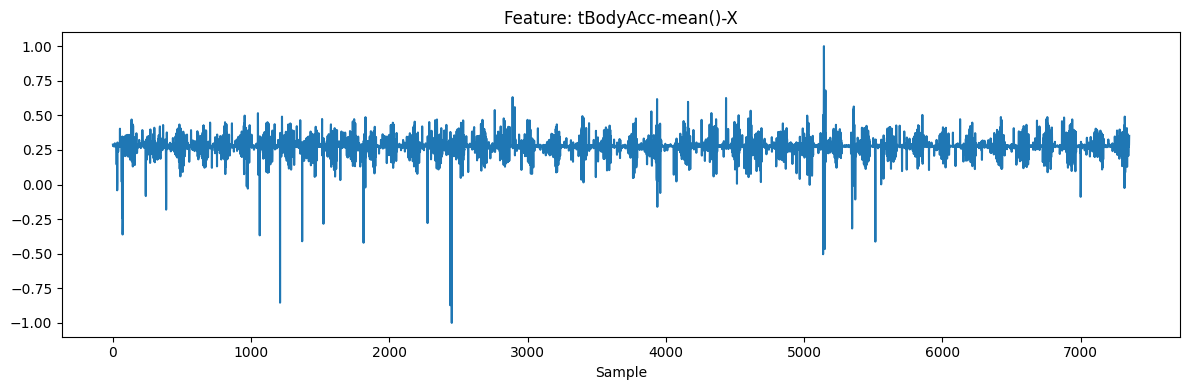

Feature:  tBodyAcc-mean()-Y
The median of the data is:  -0.0172191435
The mean of the data is:  -0.017695427357794058
The max of the data is:  1.0
The min of the data is:  -1.0
The std of the data is:  0.040810524573263465
The upper 10 percentile of the data is:  -0.0410805216
The lower 10 percentile of the data is:  0.004936000930000006


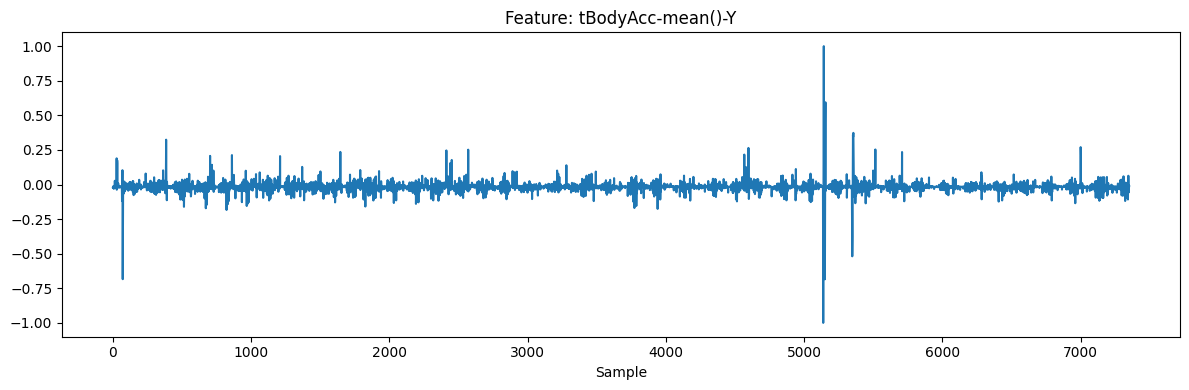

Feature:  tBodyAcc-mean()-Z
The median of the data is:  -0.10867625
The mean of the data is:  -0.10914102015124048
The max of the data is:  1.0
The min of the data is:  -1.0
The std of the data is:  0.05663518808472928
The upper 10 percentile of the data is:  -0.148389235
The lower 10 percentile of the data is:  -0.06999822779999997


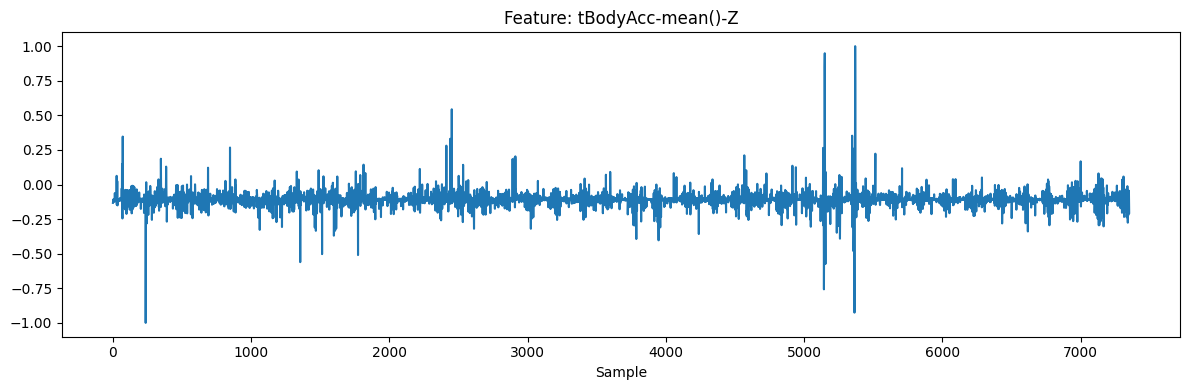

Feature:  tBodyAcc-std()-X
The median of the data is:  -0.946196395
The mean of the data is:  -0.605438451136836
The max of the data is:  1.0
The min of the data is:  -1.0
The std of the data is:  0.4487343844696267
The upper 10 percentile of the data is:  -0.996498906
The lower 10 percentile of the data is:  0.05013556470000006


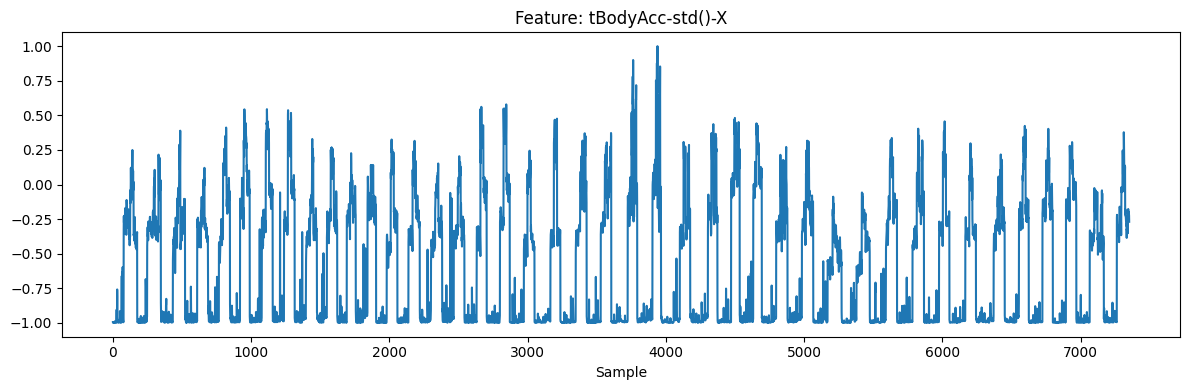

Feature:  tBodyAcc-std()-Y
The median of the data is:  -0.85189664
The mean of the data is:  -0.5109375609608324
The max of the data is:  0.91623796
The min of the data is:  -0.99987292
The std of the data is:  0.5026446547401447
The upper 10 percentile of the data is:  -0.9905078869999999
The lower 10 percentile of the data is:  0.17071454500000027


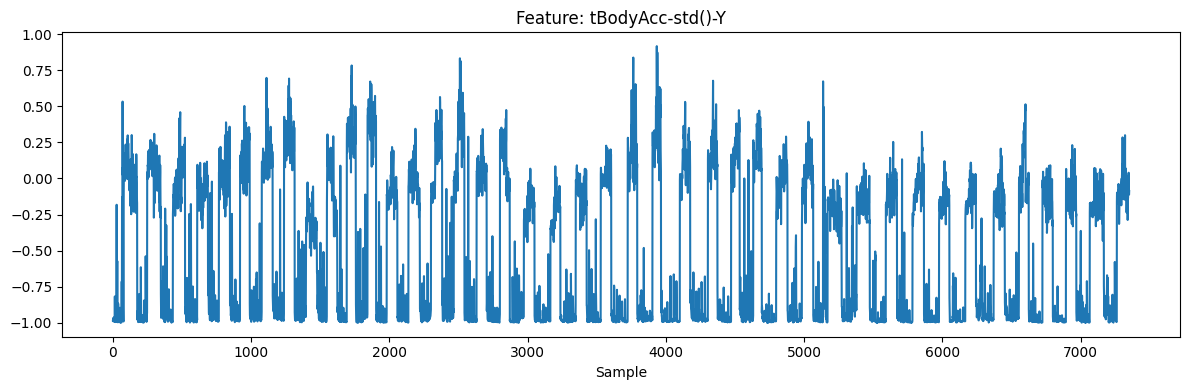

In [ ]:
# 4.1 b) put your code here
features_df = pd.read_csv("../UCI HAR Dataset/features.txt", header=None, sep=r"\s+")
feature_names = features_df[1].tolist()
feature_dict = {
    name: X_train.iloc[:, [i]].rename(columns={i: name})
    for i, name in enumerate(feature_names)
}

for index in range(0,5): # Here you can change range to see other plots
    print("Feature: ",feature_names[index])
    print("The median of the data is: ", feature_dict[feature_names[index]].median().iloc[0])
    print("The mean of the data is: ", feature_dict[feature_names[index]].mean().iloc[0])
    print("The max of the data is: ", feature_dict[feature_names[index]].max().iloc[0])
    print("The min of the data is: ", feature_dict[feature_names[index]].min().iloc[0])
    print("The std of the data is: ", feature_dict[feature_names[index]].std().iloc[0])
    print("The upper 10 percentile of the data is: ", feature_dict[feature_names[index]].quantile(0.1).iloc[0])
    print("The lower 10 percentile of the data is: ", feature_dict[feature_names[index]].quantile(0.9).iloc[0])
    plt.figure(figsize=(12, 4))
    plt.plot(feature_dict[feature_names[index]])
    plt.title(f"Feature: {feature_names[index]}")
    plt.xlabel("Sample")
    # plt.ylabel("Amplitude")
    # plt.xlim(450,700)
    plt.tight_layout()
    plt.show()

**End of Exercise 4.1**

We now consider the ground truth class labels. These are located in *train/y_train.txt* and
*test/y_test.txt* respectively.

### Exercis 4.2
**Tips**
For creating Bar plots there are at least two ways in Pandas:
+ **Bar Chart:** You need to manually calculate the counts for each activity type. You can do it either by using a for loop or using a combination of [groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) and [count](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.count.html). Finally, create bar plot using [bar](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html)
+ **Histogram:** [hist](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.hist.html) to create a Histogram.


**a)** Describe this file in terms of dimensionality, how many columns and rows are there? What do they represent (this is a very obvious question of course, don’t over-think it)?
> Your Answer (Double click to edit):

In [61]:
# 4.2 a) put you code here [if you need any]
print(f"The Y_train and Y_test data has {len(y_train)} rows and the meaning of each of the 5 different values is explained in the activity_labels.txt")
print(f"This is:\n1 WALKING\n2 WALKING_UPSTAIRS\n3 WALKING_DOWNSTAIRS\n4 SITTING\n5 STANDING\n6 LAYING")
print(f"So the data is a description of what is happening in the data over time corresponding to the X_train/X_test data")

The Y_train and Y_test data has 7352 rows and the meaning of each of the 5 different values is explained in the activity_labels.txt
This is:
1 WALKING
2 WALKING_UPSTAIRS
3 WALKING_DOWNSTAIRS
4 SITTING
5 STANDING
6 LAYING
So the data is a description of what is happening in the data over time corresponding to the X_train/X_test data


**b)** Plot the number of datapoints for each user activity (output class) as a bar chart with the class name displayed. Is the dataset balanced? Why is it important, for machine learning and classification purposes, that a dataset is balanced?



The dataset is relatively balanced, All activities are all between 420 and 537. Which is pretty close.
This is important because when you want to use this data for training AI or in general retrieve other features from the data,
you want all features to be represented equally


Text(0, 0.5, 'Count')

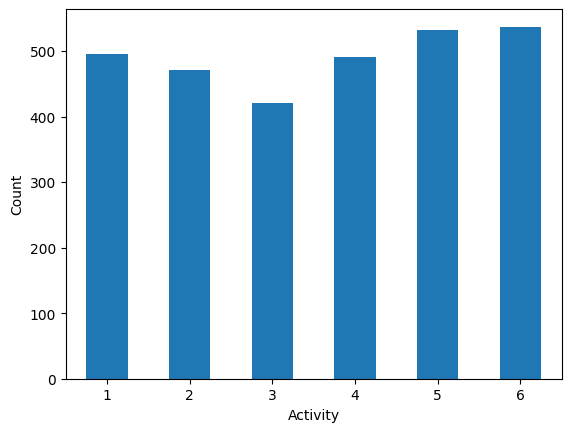

In [62]:
# 4.2 b) put your code here
counts = y_test.groupby(0).size().sort_index()
print(f"The dataset is relatively balanced, All activities are all between {counts.min()} and {counts.max()}. Which is pretty close.")
print("This is important because when you want to use this data for training AI or in general retrieve other features from the data,\nyou want all features to be represented equally")
ax = counts.plot.bar(rot=0)
ax.set_xlabel("Activity")
ax.set_ylabel("Count")

**End of Exercixe 4.2**

Next, we want to compare the values and shapes of the features for every class. The features may look
different for different classes (a truck has 2 doors and a car 3 or more) and this corresponds to the idea that
we want to differentiate and classify whether a signal from this database comes from walking or standing
for example.

**To be able to do the above said classification, you first need to couple the class labels (Y) with the feature data values (X). You have inspected the dimensions of both which provides a clue about how this should be done.**

In [63]:
# you can put your code here to couple the class labels (Y) with the feature data values (X)
X_train.columns = feature_names
train = pd.concat(
    [y_train.rename(columns={0: "activity"}), X_train],
    axis=1
)

print(train.shape)
train.head(10)

(7352, 562)


,activity,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,5,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,5,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,5,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,5,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,5,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
5,5,0.277199,-0.010098,-0.105137,-0.997335,-0.990487,-0.995420,-0.997627,-0.990218,-0.995549,...,0.019953,-0.545410,-0.844619,0.082632,-0.143439,0.275041,-0.368224,-0.849632,0.184823,-0.042126
6,5,0.279454,-0.019641,-0.110022,-0.996921,-0.967186,-0.983118,-0.997003,-0.966097,-0.983116,...,0.145844,-0.217198,-0.564430,-0.212754,-0.230622,0.014637,-0.189512,-0.852150,0.182170,-0.043010
7,5,0.277432,-0.030488,-0.125360,-0.996559,-0.966728,-0.981585,-0.996485,-0.966313,-0.982982,...,0.136382,-0.082307,-0.421715,-0.020888,0.593996,-0.561871,0.467383,-0.851017,0.183779,-0.041976
8,5,0.277293,-0.021751,-0.120751,-0.997328,-0.961245,-0.983672,-0.997596,-0.957236,-0.984379,...,0.314038,-0.269401,-0.572995,0.012954,0.080936,-0.234313,0.117797,-0.847971,0.188982,-0.037364
9,5,0.280586,-0.009960,-0.106065,-0.994803,-0.972758,-0.986244,-0.995405,-0.973663,-0.985642,...,0.267383,0.339526,0.140452,-0.020590,-0.127730,-0.482871,-0.070670,-0.848294,0.190310,-0.034417


To create distribution you can use the following:  
+ **Features to Distribution:** The [seaborn.kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) package in Python allows you to easily use Kernel Density Estimates (KDE) to turn the feature values into distributions.

#### Exercise 4.3
**Note:** In the guide this exercise is written as one paragraph. For convineince we have broken it into smaller subparts.  
**a)** Choose 10 features (it does not matter which
ones) and for every feature, plot the distributions of every class for that feature in one figure.
So, for a single feature you should have one plot which includes six distributions corresponding to the classes.


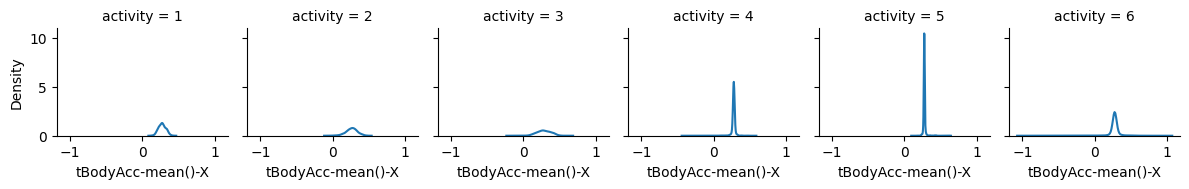

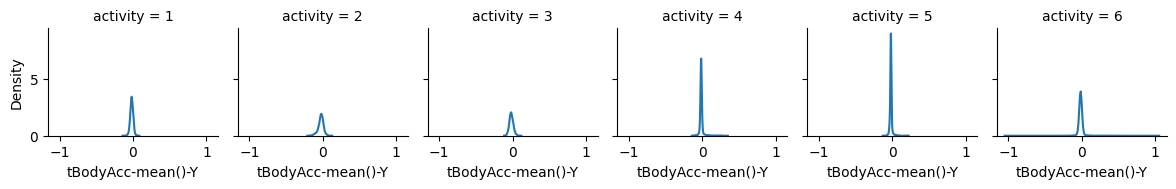

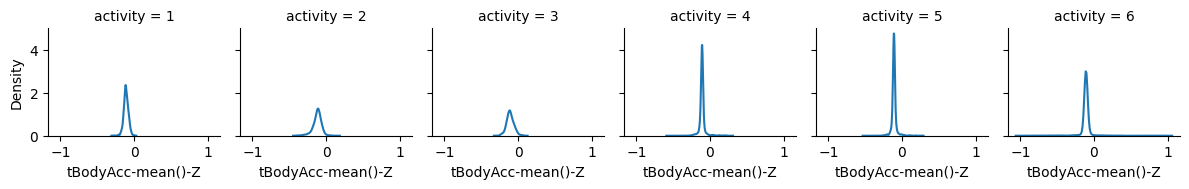

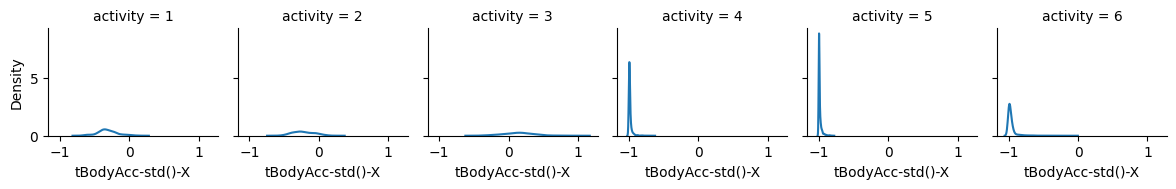

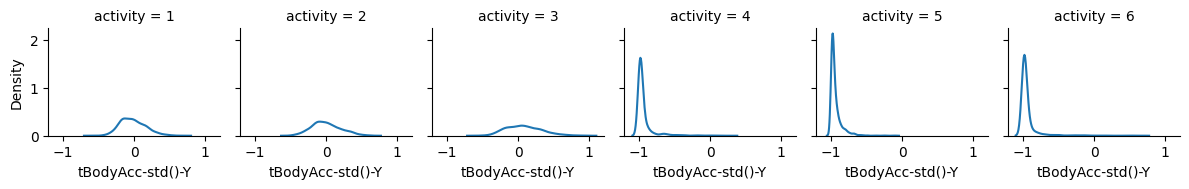

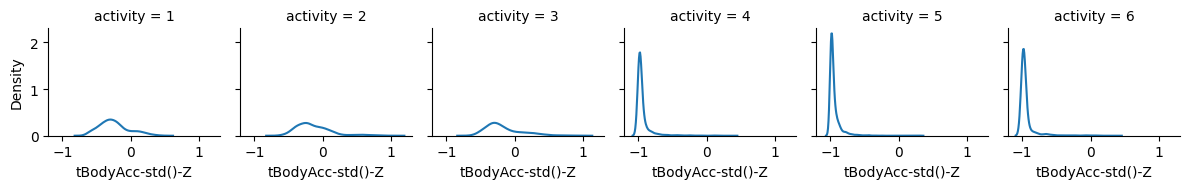

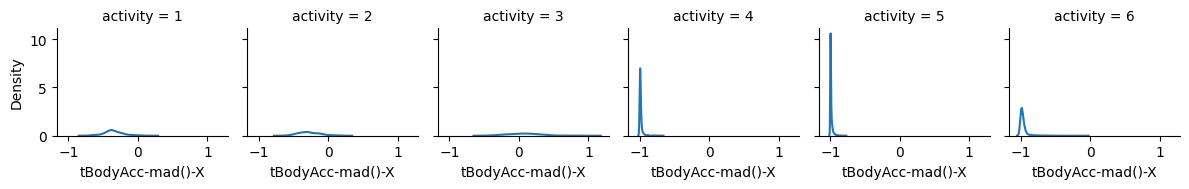

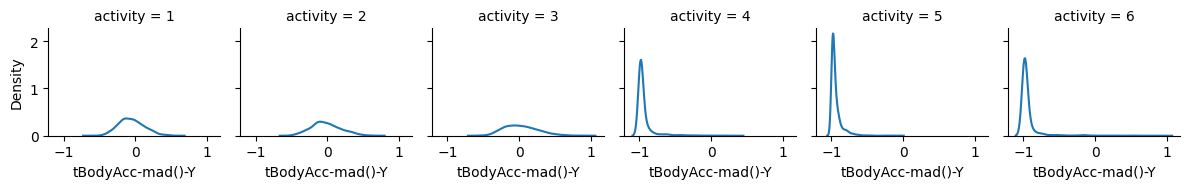

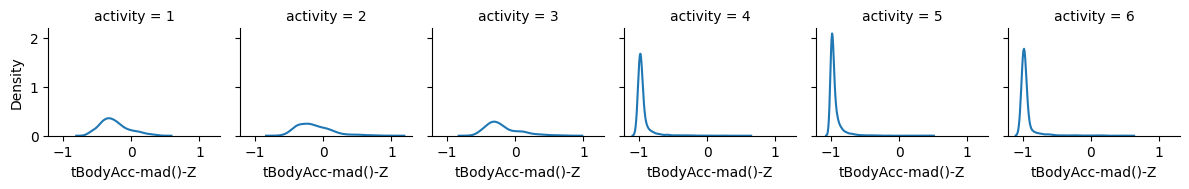

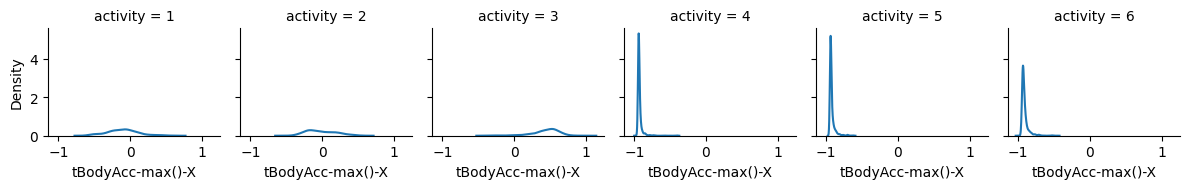

In [64]:
# 4.3 a) put your code here

# 1 : WALKING
# 2 : WALKING_UPSTAIRS
# 3 : WALKING_DOWNSTAIRS
# 4 : SITTING
# 5 : STANDING
# 6 : LAYING

for index in range(1,11):
    feature = train.columns[index]
    seaborn.displot(
        data=train,
        x=feature,
        kind="kde",
        col="activity",
        height=2,
        aspect=1
    )

**b)** Visually inspect the six different distributions in the figure for every feature and
report the nature of distributions (e.g., normal distribution or not, skewness, modality, etc.). [Be preapred to answer this to a TA.]



**c)** Is it possible to discriminate between activities based on those chosen features? Are there differences between the walking
activities and non-walking activities such as lying down and sitting? What explains these differences? [Be preapred to answer this to a TA.]

**End of Exercixe 4.3**

### Exploring the Raw Data

For this part of the assignment, we are going to focus on the raw signal
sensor data of the UCI HAR dataset. The raw data can be found in the
folders */Inertial Signals* in the *train* and *test*
folders respectively. You will find 6 files which correspond to the axes of
the accelerometer and gyroscope respectively.  
Calculate the variances of
the accelerations of all 3 axes with aid of the *total\_acc\_* files
of the 3 axes and select the corresponding body acceleration file
(*body\_acc\_*) from the axis that has the highest variance. (see also the question below)  
The raw data is somewhat different from the feature data. In the feature data,
every feature had 1 value which was calculated from each window, thus the
whole window is represented as 1 value. In the raw data, the windowing is
again used but since no features have been created from this raw data, this
data contains the individual datapoints from the windows. We first want to
reconstruct the original signal from this windowed version.


#### Exercise 4.4
**a)** Calculate the *variances* of the accelerations of all 3 axes using the *total_acc_* files. From this, check which axis has the highest variance and select the body acceleration file (*body_acc_* ) corresponding to that axis. Make use of this *body_acc_* file for the upcoming exercises. Which *total_acc_* file has the highest variance and which *body_acc_* file have you chosen?

>your answer (double click to edit):
*Body_acc_x*

In [65]:
# 4.4 a) put your code here
total_acc_x = pd.read_fwf('../UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt', header=None, delim_whitespace=True)
total_acc_y = pd.read_fwf('../UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt', header=None, delim_whitespace=True)
total_acc_z = pd.read_fwf('../UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt', header=None, delim_whitespace=True)
variance_x_all = total_acc_x.to_numpy().var()
variance_y_all = total_acc_y.to_numpy().var()
variance_z_all = total_acc_z.to_numpy().var()

print("x:", variance_x_all, ", y:", variance_y_all, ", z:", variance_z_all)

print("Because X is the highest we select body_acc_x")

x: 0.17148870382895484 , y: 0.15287742319298386 , z: 0.1279985194723366
Because X is the highest we select body_acc_x


**b)** Describe this axis file in terms of dimensionality, how many columns and rows are there? What do
they represent in this case? Hint: Use the information about the sample rate and window size provided at the start of this assignment to
determine the answers.

>your answer (double click to edit):   
*Data from the total_acc_x_train.txt is the raw total accelerometer signal on the X axis (in g). Each row is a 128-sample window. Same for the y and z axis.*
*body_acc_x_train.txt is the acceleration of only the body on the X axis, They have gotten this by removing gravity from total acceleration.*
*For each row we have 128 samples (overlapping 64 with the next sample) and we have 7352 rows that together make one long timed series data range.*


The raw data is somewhat different from the feature data. In the feature data, every feature had 1 value which was calculated from each window, thus the whole window is represented as 1 value. In the raw data, the windowing is again used but since no features have been created from this raw data, this data contains the individual datapoints from the windows. We first want to reconstruct the original signal from this windowed version.

**c)-1**
**Note: part c is divided further for ease of answering**
Reconstruct the original signal from the raw data. As mentioned at the start of this assignment, the data has 50% overlap(first 50% of the values in row 2 are the same as the last 50% values in row 1). Once you have successfully dealt with the window overlap, you can concatenate the datapoints to reconstruct the original signal.

Hint: To concatenate columns above each other, you can use [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function. The example code given below the image will give you an idea of how to use the melt function.

**NB:** Read the guide there I have one solved example with complete code.

**NB:** The expected output for the reconstructed signal for *body_acc_x_train.txt* should look like as follows:
![recon_signal.jfif](attachment:recon_signal.jfif)

In [66]:
# Example code to understand melt function


a = np.arange(1,28).reshape(9,3)
test = pd.DataFrame({'c1': a[:, 0], 'c2': a[:, 1], 'c3': a[:, 2]})
c4 = ['1', '0', '1', '0', '1', '0', '1', '0', '1']
test['c4'] = c4
print('\nTest dataframe')
print(test)
# We ignore the fourth column since it has labels only
test_slice = test.iloc[:,:3]
test_melt = test_slice.transpose()
test_melt = test_melt.melt()
print('\nAfter using the melt function on the data frame')
print(test_melt['value'])
# Note that you still have to catenate label again


Test dataframe
   c1  c2  c3 c4
0   1   2   3  1
1   4   5   6  0
2   7   8   9  1
3  10  11  12  0
4  13  14  15  1
5  16  17  18  0
6  19  20  21  1
7  22  23  24  0
8  25  26  27  1

After using the melt function on the data frame
0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
25    26
26    27
Name: value, dtype: int64


(470528,)


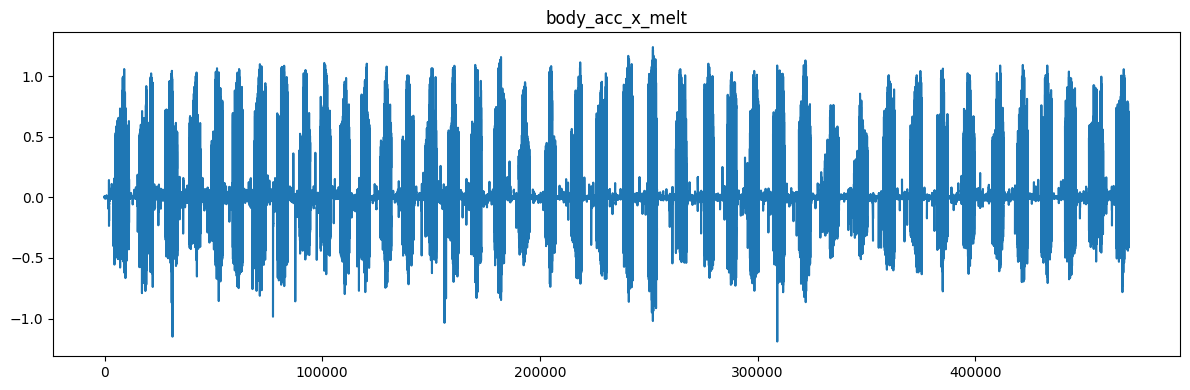

In [67]:
# 4.4 c)-1 put your code to reconstruct the original signal here
body_acc_x = pd.read_fwf('../UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt', header=None, delim_whitespace=True)
body_acc_x_slice = body_acc_x.iloc[:,:64]
body_acc_x_melt = body_acc_x_slice.transpose()
body_acc_x_melt = body_acc_x_melt.melt()["value"]
print(body_acc_x_melt.shape)

plt.figure(figsize=(12, 4))
plt.plot(body_acc_x_melt)
plt.title(f"body_acc_x_melt")
plt.tight_layout()
plt.show()


**c)-2** In the previous question what is the consequence of the overlap and how did you deal with this?[Just explain that to TA when sigining-off.]

**c)-3** Now with the above concatenated signal, couple the class labels Y. Before you do this, make sure you have the length of the class labels the same as that of the concatenated signal.

In [68]:
# 4.4 c)-3 put your code here
labels = np.repeat(y_train.iloc[:, 0].to_numpy(), 64)
# print(labels.shape)
body_acc_x_labeled = pd.DataFrame({
    "activity": labels,
    "signal": body_acc_x_melt
})

print(body_acc_x_labeled)


        activity    signal
0              5  0.000181
1              5  0.010139
2              5  0.009276
3              5  0.005066
4              5  0.010810
...          ...       ...
470523         2 -0.356609
470524         2 -0.317618
470525         2 -0.315016
470526         2 -0.330737
470527         2 -0.272348

[470528 rows x 2 columns]


**End of Exercise 4.4**

### The Time Domain and the Frequency Domain

Features can be constructed from the signal in the time domain or from the frequency domain. First we will
start to look at the signal in the frequency domain.

**Reading Materials:**
1. Time domain features
(a) http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats
(b) https://docs.scipy.org/doc/scipy-0.7.x/reference/stats.html

#### Exercise 4.5
**a)** Use your raw signal to recreate some time domain features such as [mean](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html), [standard deviation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html), [kurtosis](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.kurtosis.html) or features of your own choosing; some examples can be found in the article by Altin et al. [2]

[2] C. Altın and O. Er, “Comparison of different time and frequency domain feature extraction methods
on elbow gesture’s emg,” European Journal of Interdisciplinary Studies, vol. 5, no. 1, pp. 35–44,
2016. You can acces this article via this link: http://journals.euser.org/files/articles/ejis_may_aug_16/Cemil.pdf
Please copy the link, clicking may not work.



In [69]:
# 4.5 a) put your code here
features_time_domain = pd.DataFrame({
    "mean": body_acc_x_slice.mean(axis=1),
    "std": body_acc_x_slice.std(axis=1),
    "kurtosis": pd.DataFrame(body_acc_x_slice).kurtosis(axis=1),
    "variance": body_acc_x_slice.var(axis=1),
})

# add labels (one label per window)
features_time_domain["activity"] = y_train.iloc[:, 0]

features_time_domain.head()
print(features_time_domain)

          mean       std  kurtosis  variance  activity
0     0.004187  0.002734  0.332929  0.000007         5
1     0.000351  0.001621  1.345538  0.000003         5
2    -0.000003  0.002298  0.893114  0.000005         5
3     0.000860  0.003395  1.902629  0.000012         5
4    -0.000201  0.001573 -0.789418  0.000002         5
...        ...       ...       ...       ...       ...
7347  0.000205  0.285808  0.233359  0.081686         2
7348  0.008899  0.239878  1.235426  0.057541         2
7349 -0.010434  0.261015  0.145992  0.068129         2
7350  0.008707  0.251398  0.381061  0.063201         2
7351 -0.003729  0.260631  0.019319  0.067928         2

[7352 rows x 5 columns]


**b)** Report whether some of the time domain features have the potential to discriminate between multiple activities. For example, you could combine the means and standard deviations of the classes to reconstruct a normal distribution of the classes and visually inspect whether discrimination between activities is possible.
> your answer :
When combining all the features and construct a normal distribution of the activity classes we see graphs where we can roughly see that some activities have different behaviours compared to others. But they are not conclusive enough to be able use them to discriminate the activities with them. At least not visibly and with confidence.  

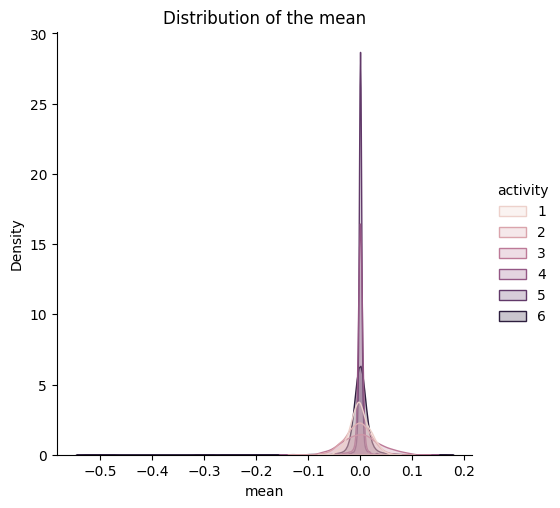

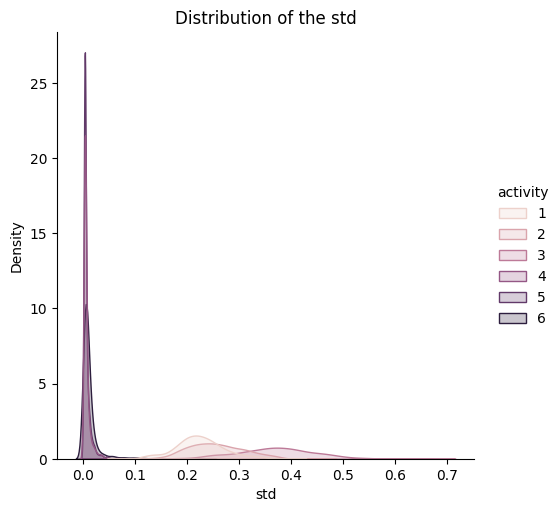

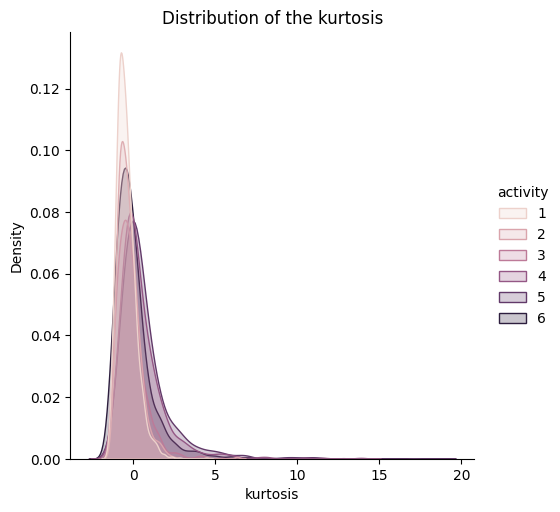

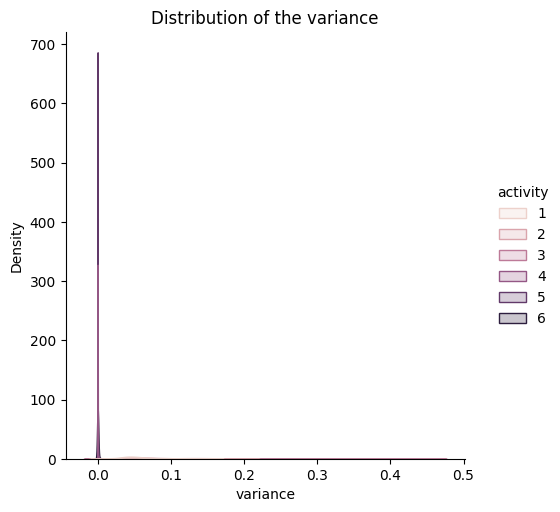

In [70]:
# 4.5 b) put your code here
features = ["mean", "std", "kurtosis", "variance"]

for bins in features:
    seaborn.displot(
        data=features_time_domain,
        x=bins,
        hue="activity",
        kind="kde",
        fill=True
    )
    plt.title(f"Distribution of the {bins}")
    plt.show()

**End of Exercise 4.5**

In some cases, looking at a signal in the time domain is not informative. Looking at your raw signal, you
will see a significant amount of noise and at first glance, any pattern is difficult to discover. Another way of
looking at the signal is in terms of the frequencies it consists of. Decomposing the signal into frequencies
and magnitudes of those frequencies can show useful patterns (dominating frequencies) in the frequency
domain. One technique to translate a signal towards the frequency domain is the Fourier transform. You
can read the excerpt of Jurafsky and Martin (section 9.3.3) [3] [link to paper]( https://www-dawsonera-com.ezproxy2.utwente.nl/readonline/9781292037936) for a quick refresh. You can watch the video
by Wiliam Cox in reference [4] if you need more background on this subject. In addition, Kulkarni [5]
provides the more theoretical background. The section in Jurafsky and Martin covers why we want to use
windowing as well as the notion that we will use a special case of the Fourier transform; the Discrete Fourier
Transform (DFT) for discrete sampled data.

An effective algorithm to compute the DFT is called the Fast Fourier Transform (FFT). Python’s *scipy*
module comes with the option to calculate the FFT of a signal with the [fft](https://docs.scipy.org/doc/scipy/tutorial/fft.html) method. This method returns the Fourier coefficients which contain a real and an imaginary part since the transfrom is based on Eulers formula. The real and imaginary part correspond to the magnitude and phase of the frequency components present in the signal. To correctly plot a spectrum, some more steps are required and these are explained in [6]. This reference also covers how the symmetry of the transform can be handled to correctly plot the resulting spectrum. Alternatively, some more information and a more practical approach to programming the FFT is given in the Python project by Punbat [7].

#### Exercise 4.6
Read the [scipy](https://docs.scipy.org/doc/scipy/tutorial/fft.html) documentation to complete the following questions.

Implement the Fourier transform to plot the spectra of all 6 activities. Keep in mind the length of
the sample you want to transform to the frequency domain and the sample rate (referred to as sample
spacing in the scipy documentation). It could be that a large peak is visible in the spectrum at 0Hz. A
frequency of 0 Hz denotes something that is referred to as a DC-offset. You can remove a DC-offset by
subtracting the mean of the data from the data as data=data-mean(data).


**a)** Before you apply the Fourier transform to the actual data, it is wise to create a test signal with known frequency components and amplitudes as given:

$sin(2 ∗ 2πx) +0.8sin(4 ∗ 2πx) +0.5sin(6 ∗ 2πx)$

The above test signal has components of 2 Hz, 4Hz and 6Hz with amplitude 1.0 , 0.8 and 0.5 respectively. To this signal, implement the Fourier transform. You can make use of the fft and fftfreq methods present in the python scipy module. Below are the plots of the test signal and its spectrum that you will see after implementation.


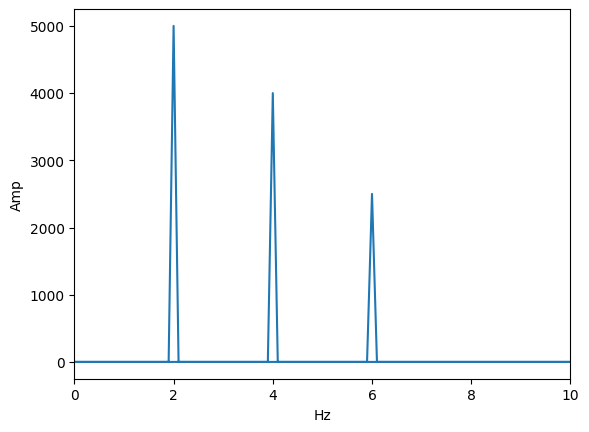

In [71]:
# 4.6 a) put your code here
# https://www.youtube.com/watch?v=YEwIjyOKFQ4
seconds = 10
sample_frequency = 1000
x = np.arange(seconds * sample_frequency) / sample_frequency
sig = np.sin(2*2*np.pi*x) + 0.8*np.sin(4*2*np.pi*x) + 0.5*np.sin(6*2*np.pi*x)
# plt.plot(sig)
# plt.show()

fft_values = fft(sig)
bins = fftfreq(len(x), 1/sample_frequency)

plt.plot(bins, np.abs(fft_values))
plt.xlabel("Hz") 
plt.ylabel("Amp")
plt.xlim(0,10)
plt.show()

**b)** Now apply the Fourier transform to your actual concatenated signal to plot the spectra of all 6 activities (one plot per activity).

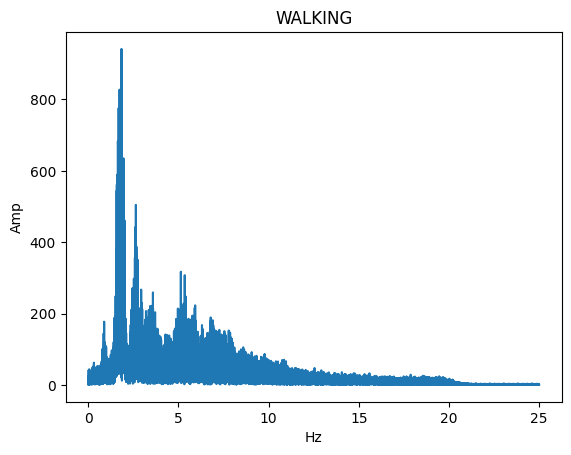

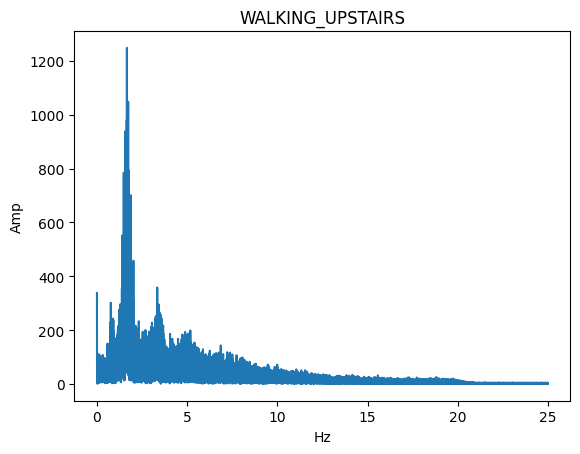

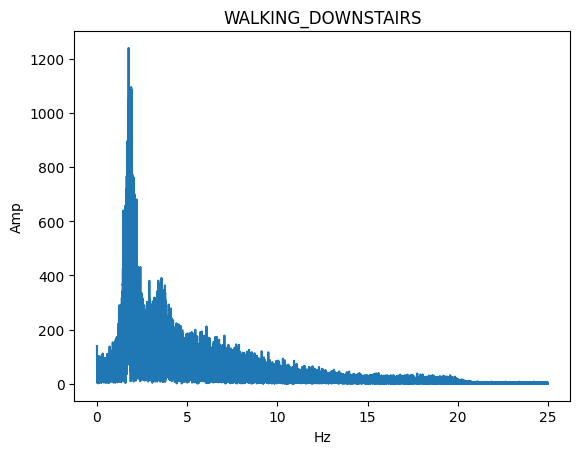

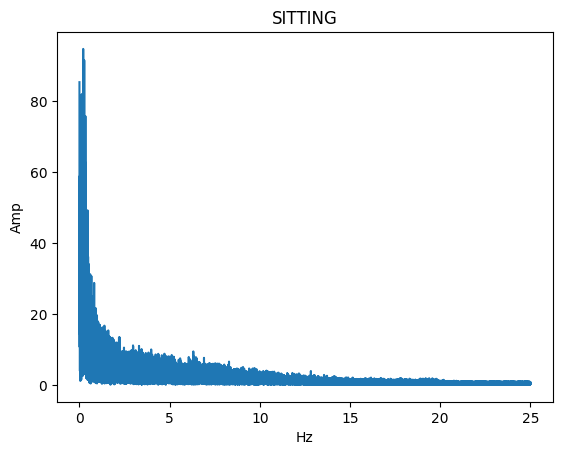

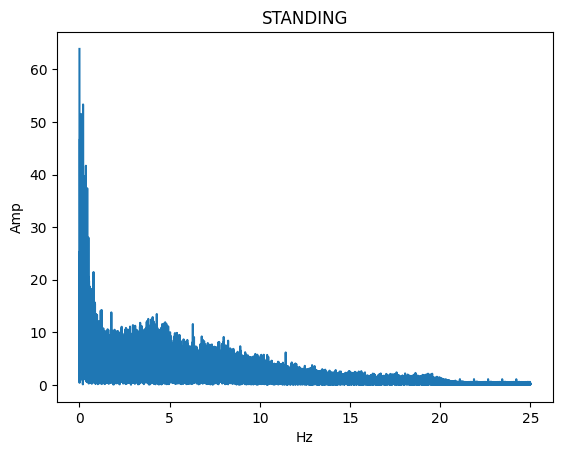

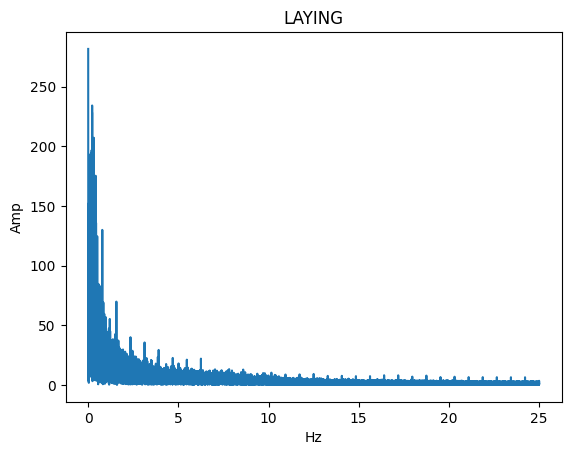

In [ ]:
# 4.6 b) put your code here
activity_map = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING",
}

for activity_value in range(1,7):
    body_signal = body_acc_x_labeled.loc[body_acc_x_labeled["activity"] == activity_value, "signal"]
    fft_values = fft(body_signal)
    bins = fftfreq(len(body_signal), 1/50)

    plt.plot(bins[bins>=0], np.abs(fft_values[bins>=0]), label=activity_value)
    plt.title(activity_map.get(activity_value, "UNKNOWN"))
    plt.xlabel("Hz") 
    plt.ylabel("Amp")
    plt.show()


**c)** After plotting the spectra for all 6 activities, determine whether it is possible to discriminate between activities based on the spectra.

>your answer :
*There is a clear distinction in the data between the passive activities and the walking activities. So we could discrimitate between these. But i would not dare to say that there is a real difference between WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS and between SITTING, STANDING, LAYING.*

**End of Exercise 4.6**

### Filtering

Accelerometer data is fairly noisy. Especially the high frequency components interfere with the signals of our interest (i.e., those corresponding to user steps). Filtering can remove certain frequencies (certain partsof the spectra we created in the previous exercise) and is often a necessity. To those unfamiliar with filters, the resource is useful -> Explanation on audio filtering presented by Wick van den Belt for WickieMedia audio tutorials https://www.youtube.com/watch?v=rkwS6vigSyE Please copy the link, clicking may not work.

#### Exercise 4.7

**a)** Which frequencies (high or low) do you expect to be present in the 6 activities of this dataset? Use the answer of this question to determine sensible cutoff frequencies for your filters in the next question.
> your answer :
*When i walk i take roughly 2 steps per second, this is roughly the same when walking up and down stairs. This would mean that we have an average of 2 Hz of movement when not stationary. When stationary you would expect almost no movement and around 0.5 HZ when moving a bit on the chair or the breathing motion. The 2 Hz also corresponds to the result of the FFT analysis.*

**b)** Apply a low-pass, a high-pass and a band-pass filter to the spectra of all 6 activities you constructed in the previous exercise. The Python scipy package already supports filters ([butterworth](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html)), for these it is important that you set the right sampling frequency and keep in mind the Nyquist frequency. The order of the filter determines the slope of the filters envelope.
**Hint:**
you can use spectral plots created by the Fourier transform from the previous exercise to visualise how your filter functions and how steep the filter’s slope is. See Figure 4.2 for an example of the spectra of a signal before and after low pass filtering (order 3 and cutoff frequency of 0.50 Hz).
![4.2.png](attachment:4.2.png)

Axes(0.125,0.11;0.168478x0.77)
Axes(0.327174,0.11;0.168478x0.77)
Axes(0.529348,0.11;0.168478x0.77)
Axes(0.731522,0.11;0.168478x0.77)
Axes(0.125,0.11;0.168478x0.77)
Axes(0.327174,0.11;0.168478x0.77)
Axes(0.529348,0.11;0.168478x0.77)
Axes(0.731522,0.11;0.168478x0.77)
Axes(0.125,0.11;0.168478x0.77)
Axes(0.327174,0.11;0.168478x0.77)
Axes(0.529348,0.11;0.168478x0.77)
Axes(0.731522,0.11;0.168478x0.77)
Axes(0.125,0.11;0.168478x0.77)
Axes(0.327174,0.11;0.168478x0.77)
Axes(0.529348,0.11;0.168478x0.77)
Axes(0.731522,0.11;0.168478x0.77)
Axes(0.125,0.11;0.168478x0.77)
Axes(0.327174,0.11;0.168478x0.77)
Axes(0.529348,0.11;0.168478x0.77)
Axes(0.731522,0.11;0.168478x0.77)
Axes(0.125,0.11;0.168478x0.77)
Axes(0.327174,0.11;0.168478x0.77)
Axes(0.529348,0.11;0.168478x0.77)
Axes(0.731522,0.11;0.168478x0.77)


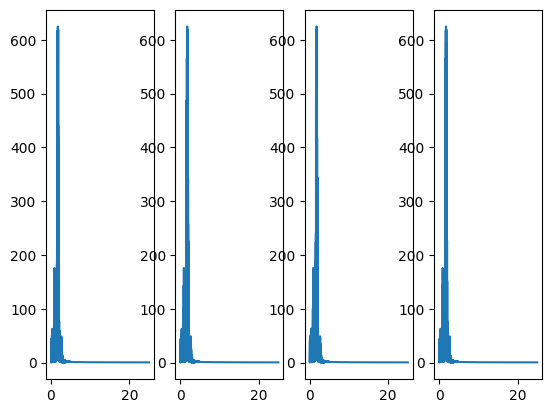

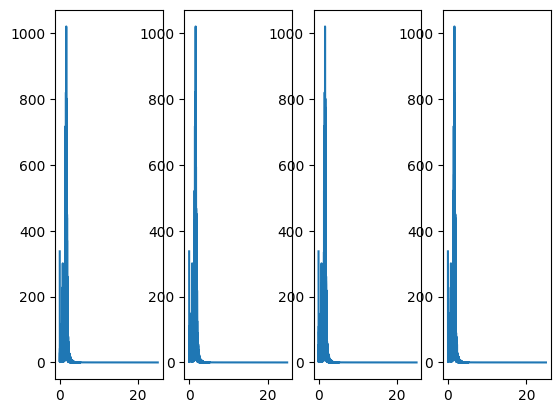

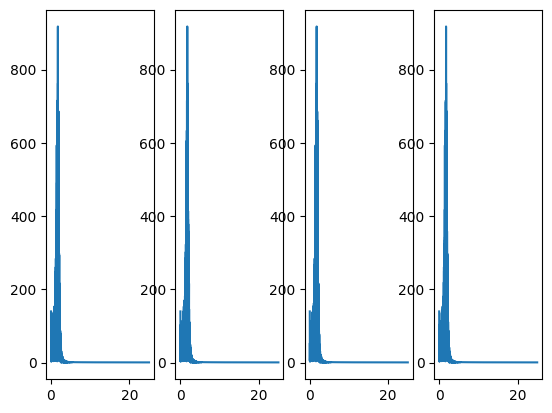

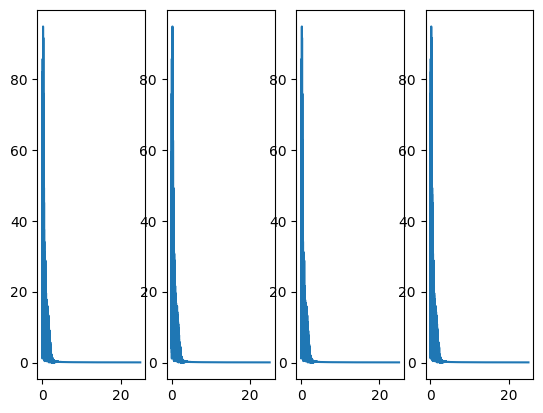

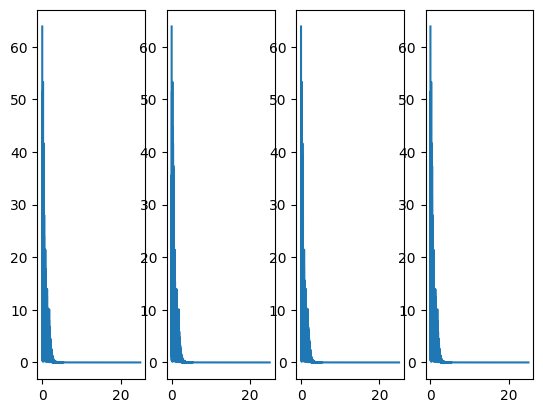

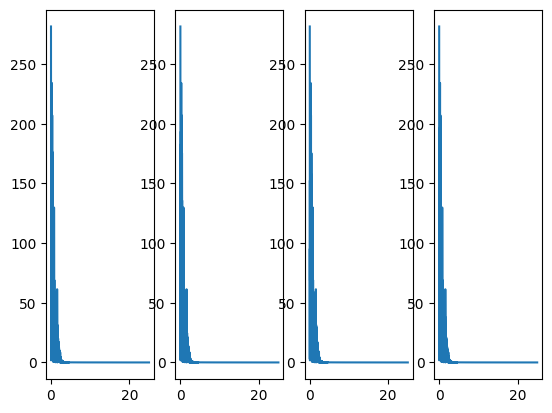

In [ ]:
# 4.7 b) put your code here
from scipy.signal import butter, filtfilt

for activity_value in range(1,7):
    body_signal = body_acc_x_labeled.loc[body_acc_x_labeled["activity"] == activity_value, "signal"]
    fs = 50
    b, a = butter(N=4, Wn=2, btype="low", fs=fs)
    signal_filt = filtfilt(b, a, body_signal)
    fft_values = fft(signal_filt)
    bins = fftfreq(len(body_signal), 1/fs)

    # plt.plot(bins[bins>=0], np.abs(fft_values[bins>=0]), label=activity_value)
    # plt.title(activity_map.get(activity_value, "UNKNOWN"))
    # plt.xlabel("Hz") 
    # plt.ylabel("Amp")
    # plt.show()
    # fig, axes = plt.subplots(1, 4)
    # for ax, act in zip(axes, [1, 2, 3, 4]):
    #     subset = train[train["activity"] == act]
    #     seaborn.kdeplot(data=subset, x=feature, ax=ax)
    #     ax.set_title(activity_map[act])
    fig, axes = plt.subplots(1, 4)

    for ax in axes:
        # body_signal = body_acc_x_labeled.loc[body_acc_x_labeled["activity"] == activity_value, "signal"]
        # fft_values = fft(body_signal)
        # bins = fftfreq(len(body_signal), 1/50)
        print(ax)
        ax.plot(bins[bins>=0], np.abs(fft_values[bins>=0]))
        # ax.set_title(activity_map.get(activity_value, "UNKNOWN"))
        # ax.set_xlabel("Hz")
        # ax.set_ylabel("Amp")
    plt.
    plt.show()

# for activity_value in range(1,7):
#     signal = body_acc_x_labeled.loc[body_acc_x_labeled["activity"] == activity_value, "signal"]
#     fs = 50
#     b, a = butter(N=4, Wn=2, btype="low", fs=fs)
#     signal_filt = filtfilt(b, a, body_signal)
#     fft_values = fft(signal)
#     bins = fftfreq(len(signal_filt), 1/fs)

#     plt.plot(bins[bins>=0], np.abs(fft_values[bins>=0]), label=activity_value)
#     plt.title(activity_map.get(activity_value, "UNKNOWN"))
#     plt.xlabel("Hz") 
#     plt.ylabel("Amp")


**c)** Report which of the filters is better for each of the activity and what settings you have used.

>your answer :

**End of Exercise 4.7**

#### Dynamic Time Warping and Classification with K-nearest Neighbours

Now that the dataset has been explored and the pre-processing of data has been handled, it is time to perform actual classification of the 6 activities. We cannot however just classify the raw signals or feature signals as is, since the signals differ in length and general structure. Even though the data from a walking activity is produced by walking, not all walking signals will be the same since everyone walks in a different manner and the signals may thus vary in time and speed. One way to measure the similarity between two time series is Dynamic Time Warping (DTW). For a very intuitive explanation you can turn to reference [9]. A Python Notebook by Punbatra [10] explains the algorithm with a hands on approach. The more theoretical background can be found in Chapter 4 of the book by Muller [11]. Once we have computed the similarity ¨between signals, we can group or cluster the signals that are similar. These clustered signals likely belong to the same class (activity). A classifier can be trained on examples of signals from the train set and use this information to determine what activity the signals in the test set belongs to. One classifier that can beused is the K-nearest Neighbour classifier. An intuitive explanation of the classifier is given in reference [12]. Some theoretical background can be found in Chapter 3.1 and 3.2 in the book by Murty [13]. Simple classifiers such as K-Nearest Neighbors can achieve high accuracy while using DTW as a distance metric
for classifying/clustering time series data.

**Additional References for your perusal**:

[9] Explanation of DTW presented by Thales Sehn Korting ¨ https://www.youtube.com/watch?v=_K1OsqCicBY Please copy the link, clicking may not work.

[10] Nipun Batra gives a more practical approach to the DTW algorithm in this Python example https://github.com/nipunbatra/ProgramaticallyUnderstandingSeries/blob/master/dtw.ipynb
Please copy the link, clicking may not work.

[11] The book Information Retrieval for Music and Motion by Meinard Muller. You can read Chapter 4 ¨
for the information about Dynamic Time warping. The book is accessible with your student account
via the following link. https://link-springer-com.ezproxy2.utwente.nl/content/pdf/10.1007%2F978-3-540-74048-3.pdf Please copy the link, clicking may not work.

[12] Video on KNN classification by Augmented Startups https://www.youtube.com/watch?v=MDniRwXizWo Please copy the link, clicking may not work.

#### Exercise 4.8
**a)** The tutorial in reference [13] applies DTW on derived features from the activity recognition data set. Apply the same technique but now on the raw data (all the raw data present in this dataset!). Include the classification results (the confusion matrices) for both the feature data and the raw data and reflect on the results and the differences. The complete classification of the tutorial can take very long (hours!) depending on your computer. It is okay if you leave on your laptop overnight, but if things take too long it is also fine to apply the classifier on a subset of the data. However, then you can expect that the performance in classification will be less (generally the more data the better) and you should mention this. The code allows you to play with the number of neighbours (parameter k) if you would like to see how this changes classification performance.

**Reference:(This is to assist you in completing this exercise)**

[13] Python tutorial on DTW and KNN classification of the UCI Har dataset by Mark Regan.
https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb Please copy the link,
clicking may not work.

**Note:** The code is already copied below for your ease of reference.


In [74]:
#Given functions from the tutorial
try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
    Number of neighbors to use by default for KNN
    max_warping_window : int, optional (default = infinity)
    Maximum warping window allowed by the DTW dynamicprogramming function
    subsample_step : int, optional (default = 1)
    Step size for the timeseries array. By setting subsample_step = 2,
    the timeseries length will be reduced by 50% because every second
    item is skipped. Implemented by x[:, ::subsample_step]
    """
    def __init__(self, n_neighbors=5, max_warping_window=10000,subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        Training data set for input into KNN classifer
        l : array of shape [n_samples]
        Training labels for input into KNN classifier
        """
        self.x = x
        self.l = l
    def _dtw_distance(self, ts_a, ts_b, d=lambda x, y: abs(x - y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.
        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
        Two arrays containing n_samples of timeseries data
        whose DTW distance between each sample of A and B
        will be compared
        d : DistanceMetric object (default = abs(x-y))
        the distance measure used for A_i - B_j in the
        DTW dynamic programming function
        Returns
        -------
        DTW distance between A and B"""
    #      Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = float('inf') * np.ones((M, N))
        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i - 1, 0] + d(ts_a[i], ts_b[0])
        for j in range(1, N):
            cost[0, j] = cost[0, j - 1] + d(ts_a[0], ts_b[j])
        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j - 1], cost[i - 1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])
            # Return DTW distance given window
        return cost[-1, -1]

    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        y : array of shape [n_samples, n_timepoints]
        Returns
        -------
        Distance matrix between each item of x and y with
        shape [training_n_samples, testing_n_samples]
        """
        # Compute the distance matrix
        dm_count = 0
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if (np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            p = ProgressBar(shape(dm)[0])
            for i in tqdm(xrange(0, x_s[0] - 1)): #tqdm for progress bar
                for j in xrange(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],y[j, ::self.subsample_step])
                    dm_count += 1
#                     p.animate(dm_count) # progressbar was being used here
                    # Convert to squareform
                    dm = squareform(dm)
            return dm
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0]))
            dm_size = x_s[0] * y_s[0]
            p = ProgressBar(dm_size)
            for i in tqdm(range(0, x_s[0])): #tqdm is used to print the progress
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
#                     p.animate(dm_count) # progressbar was being used here
            return dm

    def predict(self, x):
        """Predict the class labels or probability estimates for
        the provided data
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        Array containing the testing data set to be classified
        4
        Returns
        -------
        2 arrays representing:
        (1) the predicted class labels
        (2) the knn label count probability"""
        dm = self._dist_matrix(x, self.x)
        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]
        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1] / self.n_neighbors
        return mode_label.ravel(), mode_proba.ravel()

#Progressbar is not used because of a bug which prints the progress in next line.
class ProgressBar:
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 50
        self.__update_amount(0)

    def animate(self, iter):
        print('\r', self, end='')
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

In [75]:
# 4.8 a) put your code here

**b)** Also reflect on the ability to discriminate between the 6 activities. Note that the DTW algorithm uses brute force to compare all aspects of a signal.

> your answer

### Time Series Comparison and Prediction

For this assignment, we will switch to another dataset, namely the Kaggle Berkeley Earth Surface Temperature Study dataset. This dataset can be downloaded from reference [14]. This extensive data set is created by combining multiple existing archives and it allows groupings by country or city of interest. The dataset does not need an explanation as with the UCI HAR dataset and its usage is straightforward.

**Reference:**

[14] Berkeley EarthSurface Temperature Study dataset. Accessible via the link below.
https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data Please copy the link, clicking may not work.

**Reading Material (This is to assist you in completing this exercise)**

Time series prediction
1. https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Time_Series_Analysis/Time_Series_AirPassenger.ipynb
2. https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/


In [76]:
# for this exercise you need statsmodel package

#### Exercise 4.9
**a)** Plot the yearly temperatures for Norway, Finland, Singapore and Cambodia. Use DTW to measure the similarities between the temperature data of these countries and reflect on the results.

In [77]:
# 4.9 a) put your code here

**b)** Look at the tutorial on time series data by Aarshay Jain [15]. Use the Dickey-Fuller test to evaluate the stationarity of the temperature data for the four countries.

**Reference:**

[15] Time Series Modelling and Forecastig by Aarshay Jain. Tutorial and Python code can be accessed through the link below. https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/ Please copy the link, clicking may not work.

In [78]:
# 4.9 b) put your code here

**c)** Temperature and weather data includes seasons, day and night temperature changes as well as global warming. This seasonality and the slow trends (such as global warming) can be removed by differencing and decomposition techniques. Apply these techniques from the tutorial to de-trend the data and remove seasonality. Again apply DTW on your newly obtained processed data and reflect on the results.
> your answer

In [79]:
# 4.9 c) put your code here

**d)** Read the section on Forecasting models in the tutorial and apply the AR, AM and ARIMA model on the temperature data of one of the four countries. Reflect on the results of the models on the data. Be clear in your methodology and explain which values for p, q and d you use based on the ACF and PACF plots.

In [80]:
# 4.9 d) put your code here

**e)** Select one of the models from the question above to make a temperature forecast (using for example the **forecast()** and **predict()** methods from the models) for the next seven days for your country of choice. You can take the next seven days from the last date present in the dataset of that country.

In [81]:
# 4.9 e) put your code here

Reflect on the quality of the prediction.
> your answer :